# Praca domowa 6
#### Mateusz Grzyb

## Wczytanie bibliotek

In [844]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth

from scipy.stats import variation

## Wczytanie danych

In [845]:
data = pd.read_csv('../../clustering_R3.csv')
data.columns = ['X', 'Y', 'Z']

data

X           Y          Z
0    152.077986  197.910402   1.095707
1    145.520487  202.128032   2.738826
2    155.441273  198.122696   0.640457
3    150.389105  206.808383   0.686486
4    149.863221  205.417527   3.555814
..          ...         ...        ...
995  327.058500   95.042417   5.819534
996  379.871471  118.620443  13.329955
997  386.363714   97.265599   8.635707
998  331.269212  100.623285   6.228514
999  359.119784   99.953503  20.211148

[1000 rows x 3 columns]

## Eksploracja danych
Najpierw obejrzymy wczytany zbiór z kilku stron, by wizualnie ocenić liczbę poszukiwanych klastrów.

In [846]:
def perspectives_plot(data, color):

    fig = plt.figure(figsize=(16, 16))
    angles = [(30, -45), (10, -90), (10, 0), (80, -45)]

    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.scatter(data.X, data.Y, data.Z, c=color, alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(angles[i][0], angles[i][1])

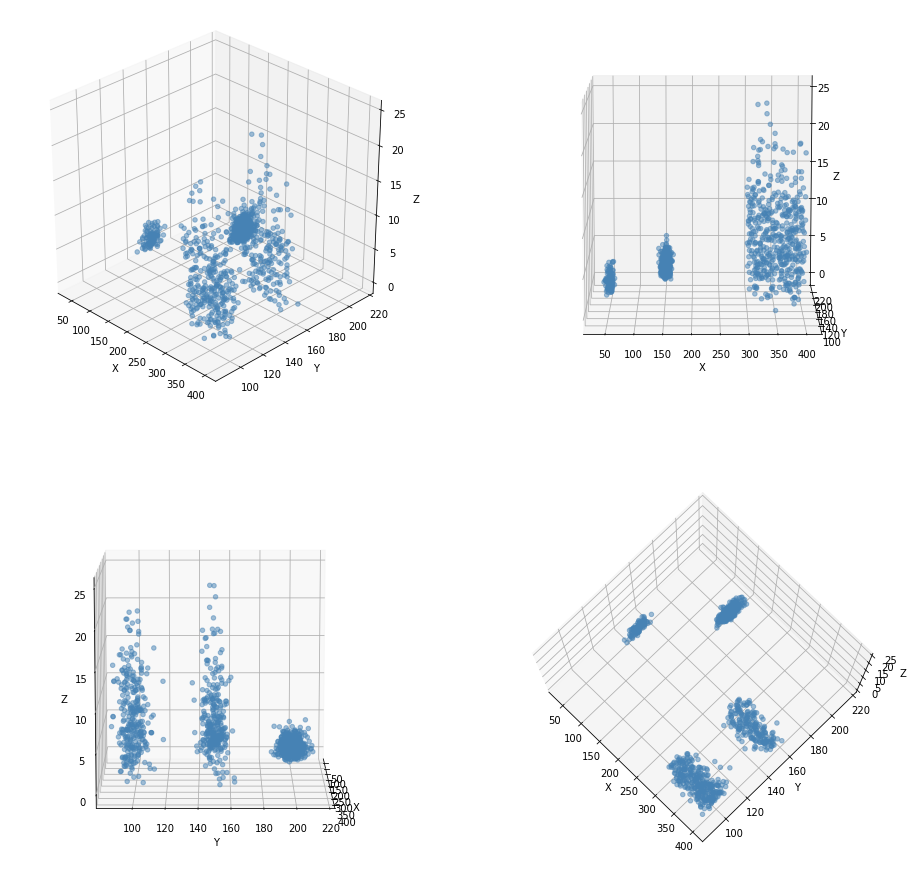

In [847]:
perspectives_plot(data, 'steelblue')

Nie ma wątpliwości - mamy doczynienia z 4 klastrami. Pierwsze 2 klastry wykazują większą wariancję, a drugie 2 mniejszą.

Dobrze również widać, że dane mogą wymagać skalowania.

Dane możemy również z powodzeniem wizualizować z użyciem TSNE (t-distributed Stochastic Neighbor Embedding). Przekształcenie to zachowuje widoczność separacji klastrów.

In [848]:
def tsne_plot(data, color):
    flat_data = TSNE(n_components=2).fit_transform(data)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(flat_data[:, 0], flat_data[:, 1], c=color, alpha=0.5)
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')

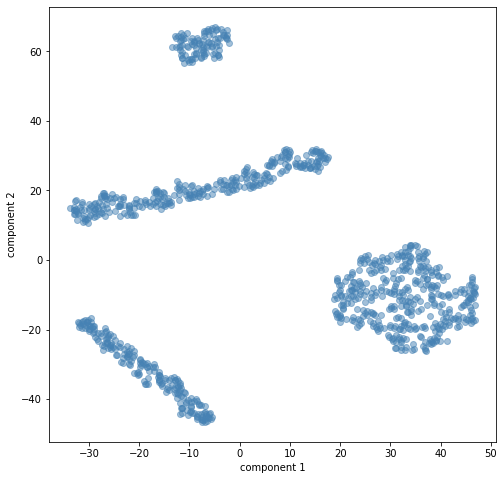

In [849]:
tsne_plot(data, 'steelblue')

## Skalowanie danych

Tak jak zauważyliśmy wcześniej, dane mogą wymagajać skalowania. Poddamy je działaniu kilku metod - MinMaxScaler, StandardScaler, RobustScaler.

In [850]:
scaled_data_1 = pd.DataFrame(MinMaxScaler().fit_transform(data))
scaled_data_1.columns=['X', 'Y', 'Z']

scaled_data_2 = pd.DataFrame(StandardScaler().fit_transform(data))
scaled_data_2.columns=['X', 'Y', 'Z']

scaled_data_3 = pd.DataFrame(RobustScaler().fit_transform(data))
scaled_data_3.columns=['X', 'Y', 'Z']

Obejrzyjmy efekty skalowania.

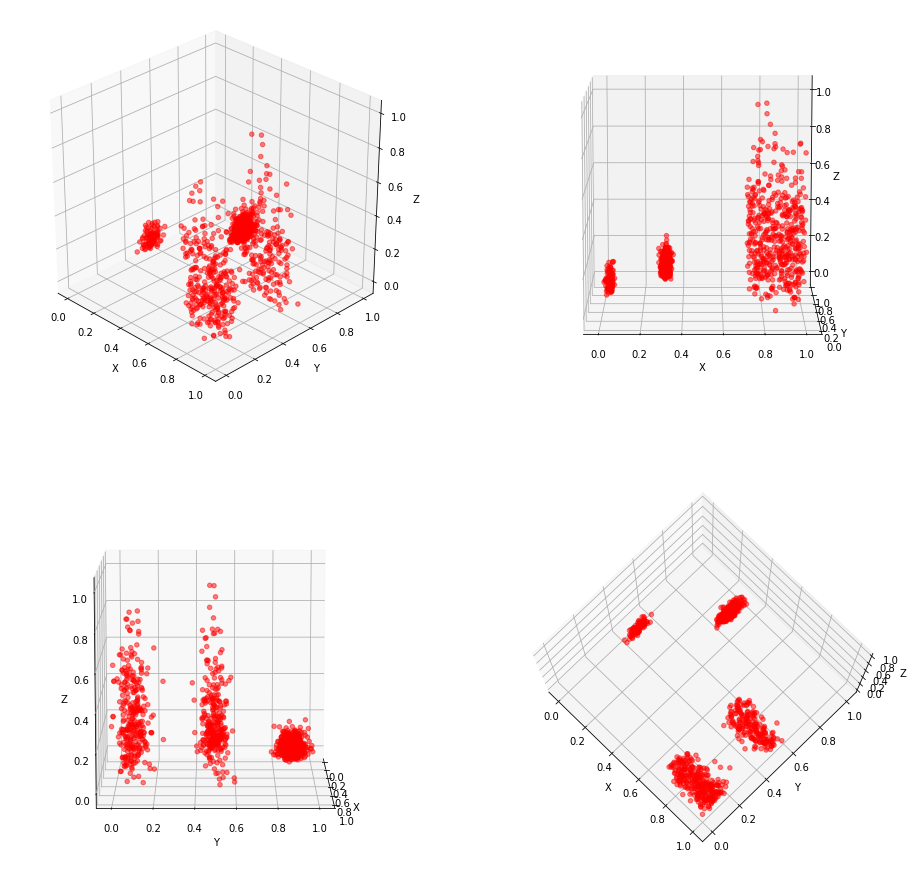

In [851]:
perspectives_plot(scaled_data_1, 'red')

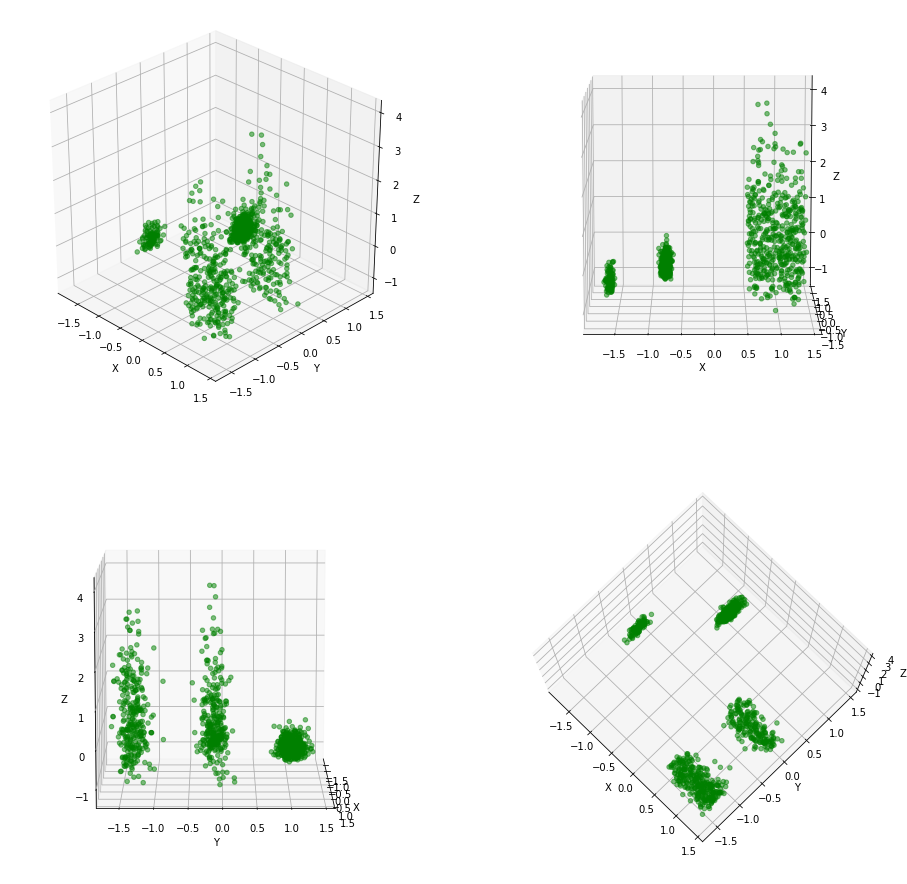

In [852]:
perspectives_plot(scaled_data_2, 'green')

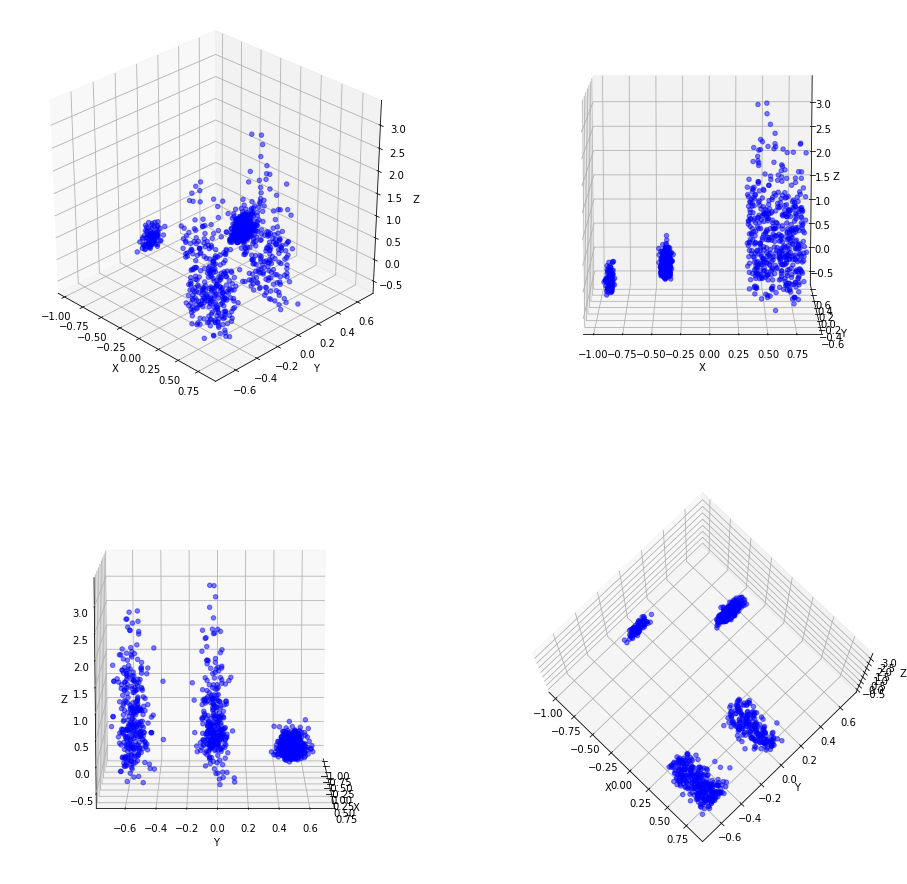

In [853]:
perspectives_plot(scaled_data_3, 'blue')

Wszystko się zgadza. Efekty poszczególnych metod różnią się.

## Metryki

Dla wszystkich podziałów policzymy wszystkie 3 proponowane metryki, to znaczy:

* Silhouette Score

> Mean Silhouette Coefficient of all samples.
>
> The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

* Calinski Harabasz Score

> It is also known as the Variance Ratio Criterion.
>
> The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

* Davies Bouldin Score

>The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to >between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.
>
>The minimum score is zero, with lower values indicating better clustering.

W tym celu zdefiniujemy poniższą funkcję.

In [854]:
def predict_and_score(data, model):
    model.fit(data)
    if hasattr(model, 'labels_'):
        prediction = model.labels_.astype(np.int)
    else:
        prediction = model.predict(data)
        
    _silhouette_score = silhouette_score(data, prediction)
    _calinski_harabasz_score = calinski_harabasz_score(data, prediction)
    _davies_bouldin_score = davies_bouldin_score(data, prediction)
    
    scores = {'silhouette_score': _silhouette_score, 'calinski_harabasz_score': _calinski_harabasz_score, 'davies_bouldin_score': _davies_bouldin_score}
    
    return prediction, scores

Zbierzemy teraz wyniki dla algorytmów KMeans, AgglomerativeClustering (ward), AgglomerativeClustering (single) oraz MeanShift, dla różnych metod skalowania danych (w tym braku skalowania). Wyniki zapiszemy w ramce danych results, wraz z informacją, czy dany podział wydał nam się wizualnie poprawny.

In [855]:
results = pd.DataFrame(columns=['model', 'scaling', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'visually_correct'])

results

Empty DataFrame
Columns: [model, scaling, silhouette_score, calinski_harabasz_score, davies_bouldin_score, visually_correct]
Index: []

## Klasteryzacja

### K-means

#### Brak skalowania

In [856]:
model = KMeans(n_clusters=4)
prediction, scores = predict_and_score(data, model)

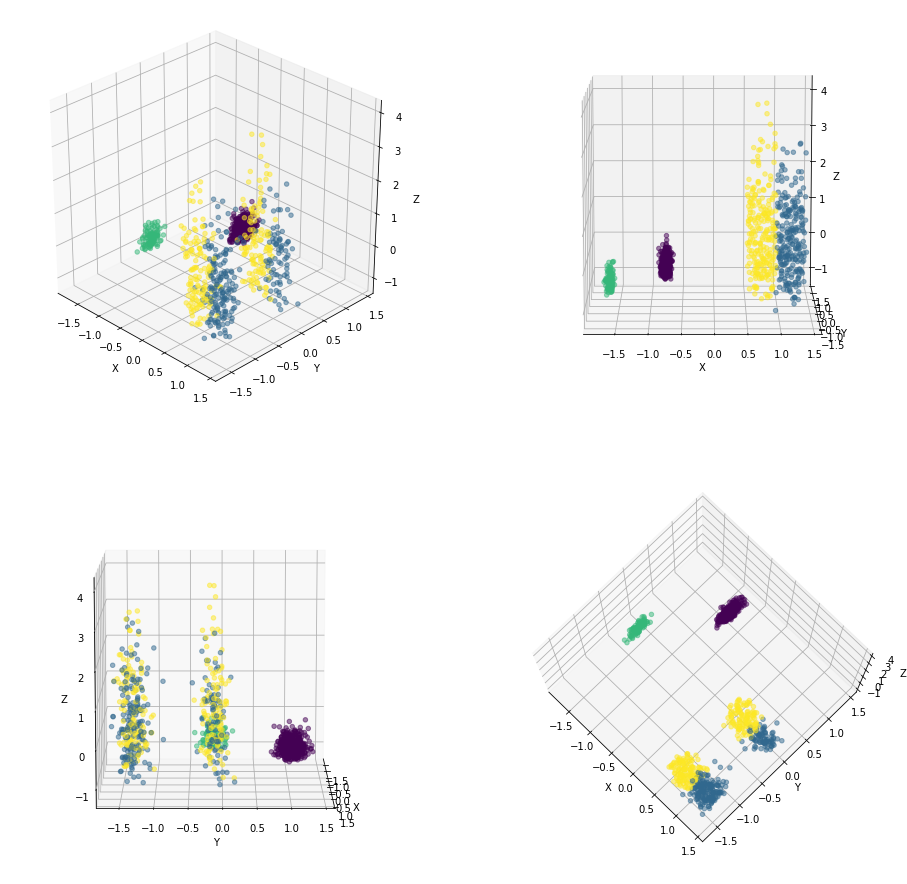

In [857]:
perspectives_plot(scaled_data, prediction)

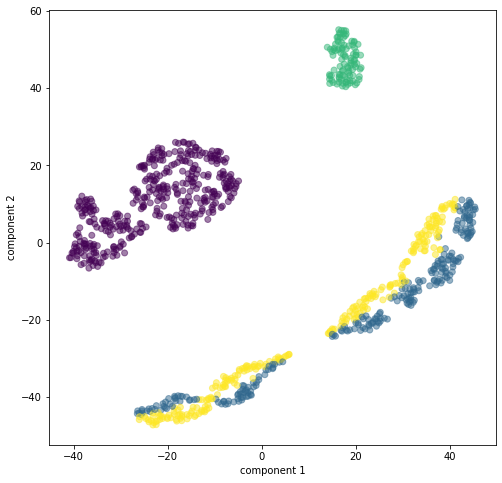

In [858]:
tsne_plot(scaled_data, prediction)

In [859]:
scores

{'silhouette_score': 0.6614753522212494,
 'calinski_harabasz_score': 11023.10869743483,
 'davies_bouldin_score': 0.6279373864488536}

In [860]:
result = pd.Series({'model': 'KMeans', 'scaling': 'none',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

#### MinMaxScaler

In [861]:
model = KMeans(n_clusters=4)
prediction, scores = predict_and_score(scaled_data_1, model)

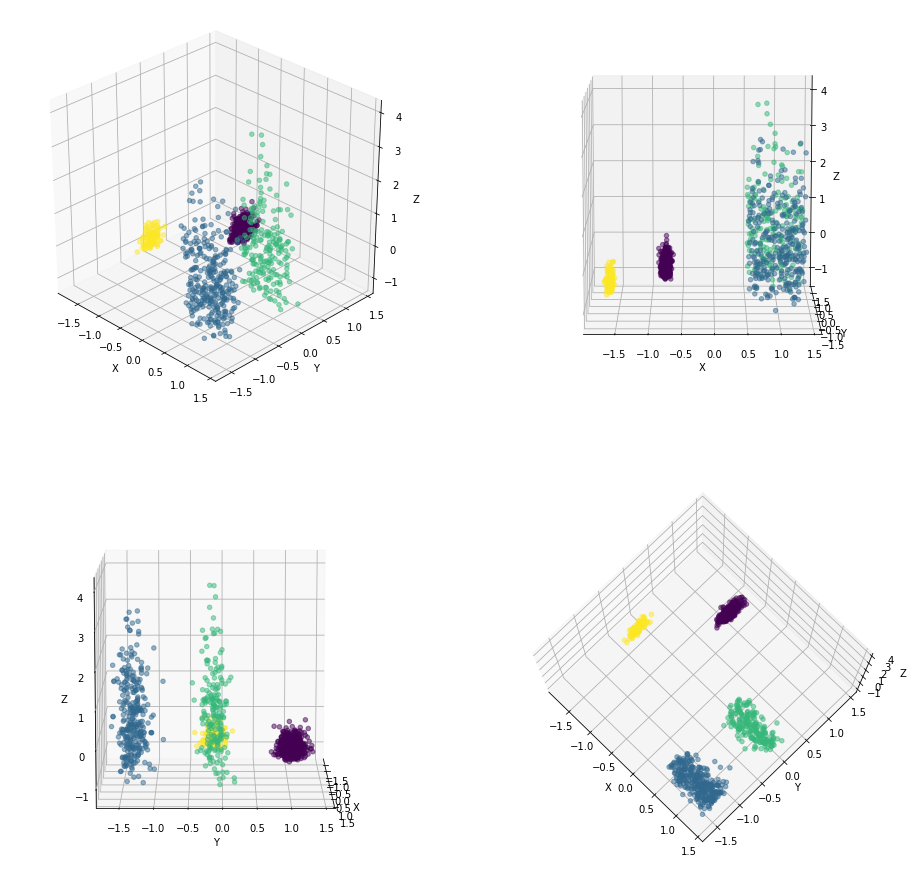

In [862]:
perspectives_plot(scaled_data, prediction)

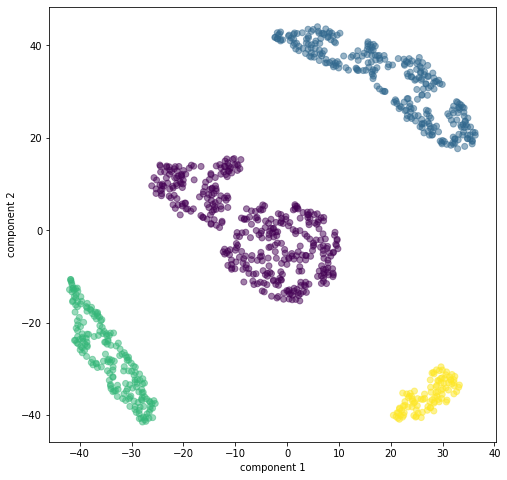

In [863]:
tsne_plot(scaled_data, prediction)

In [864]:
scores

{'silhouette_score': 0.6643641692874769,
 'calinski_harabasz_score': 3269.0231326701196,
 'davies_bouldin_score': 0.607814385262746}

In [865]:
result = pd.Series({'model': 'KMeans', 'scaling': 'MinMaxScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### StandardScaler

In [866]:
model = KMeans(n_clusters=4)
prediction, scores = predict_and_score(scaled_data_2, model)

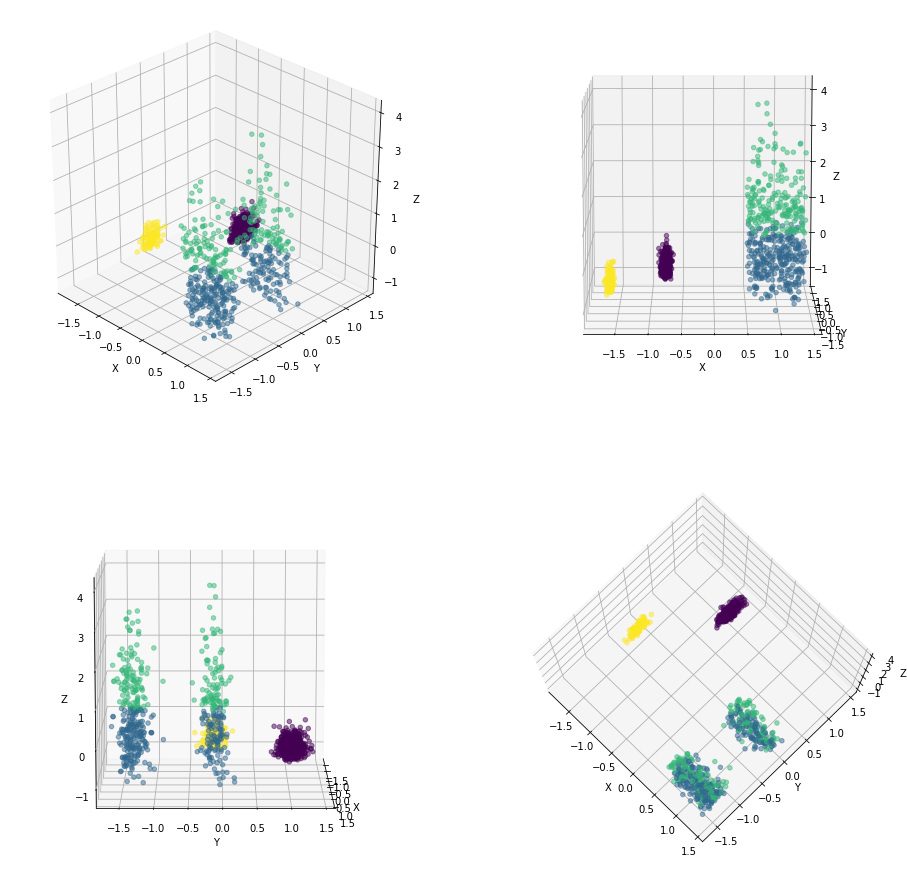

In [867]:
perspectives_plot(scaled_data, prediction)

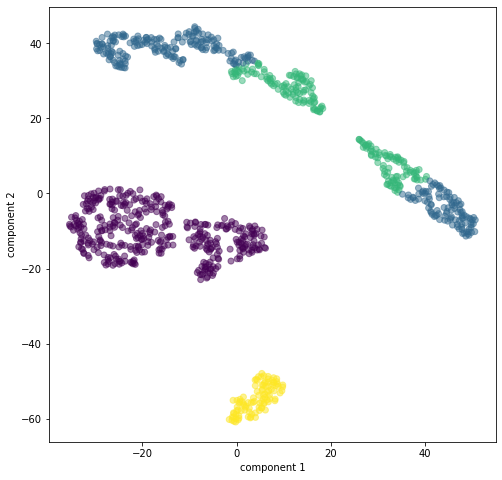

In [868]:
tsne_plot(scaled_data, prediction)

In [869]:
scores

{'silhouette_score': 0.5912551358538592,
 'calinski_harabasz_score': 2205.005027340979,
 'davies_bouldin_score': 0.6931099659005572}

In [870]:
result = pd.Series({'model': 'KMeans', 'scaling': 'StandardScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

#### RobustScaler

In [871]:
model = KMeans(n_clusters=4)
prediction, scores = predict_and_score(scaled_data_3, model)

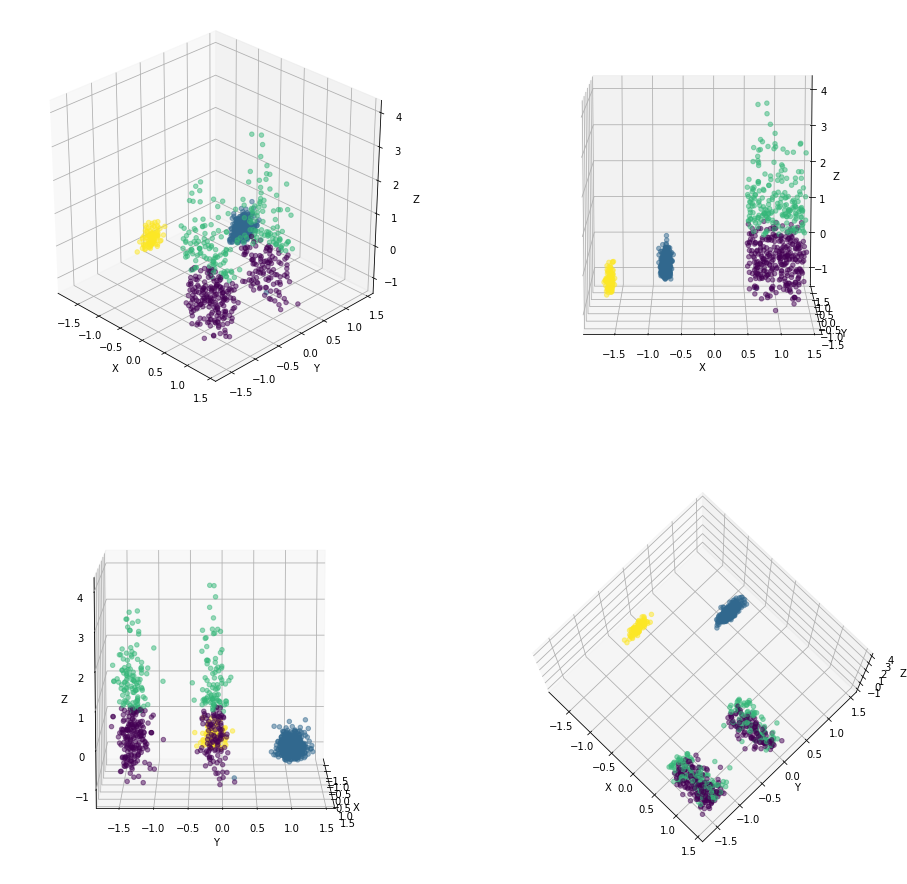

In [872]:
perspectives_plot(scaled_data, prediction)

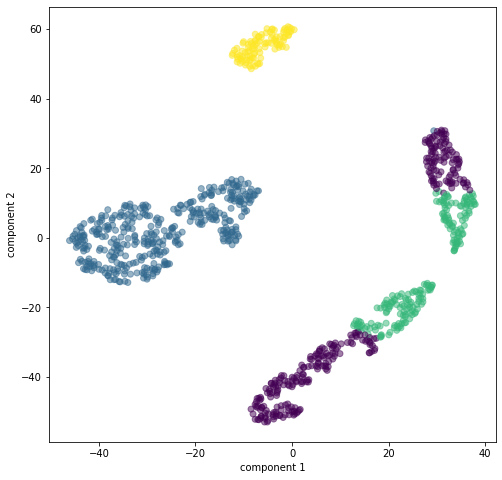

In [873]:
tsne_plot(scaled_data, prediction)

In [874]:
scores

{'silhouette_score': 0.5891957818641835,
 'calinski_harabasz_score': 2148.0639049867054,
 'davies_bouldin_score': 0.6034424409326044}

In [875]:
result = pd.Series({'model': 'KMeans', 'scaling': 'RobustScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

### AffinityPropagation - ward

#### Brak skalowania

In [876]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
prediction, scores = predict_and_score(data, model)

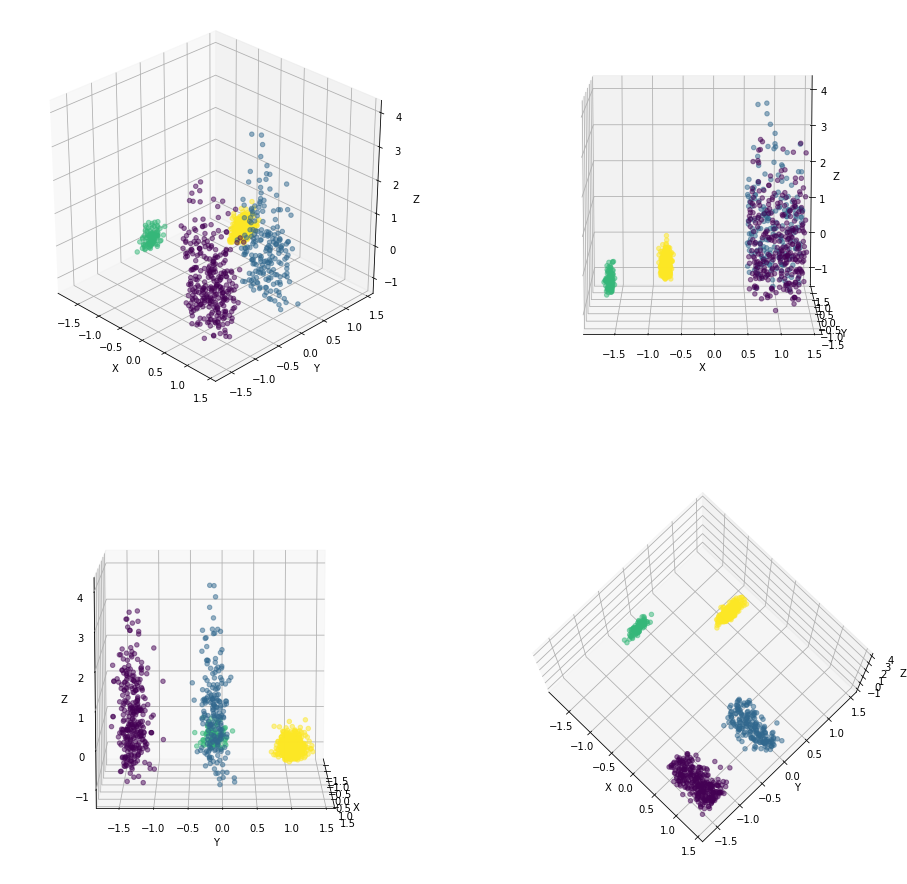

In [877]:
perspectives_plot(scaled_data, prediction)

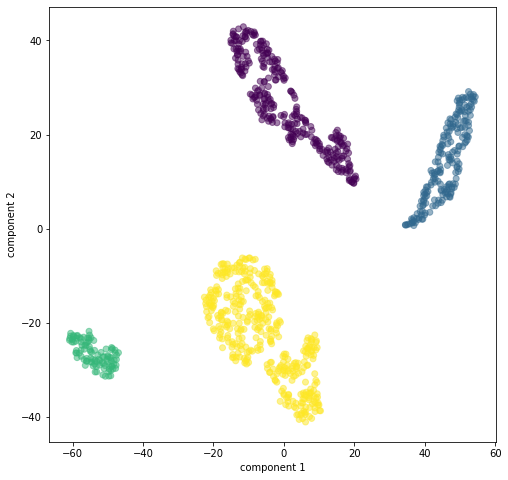

In [878]:
tsne_plot(scaled_data, prediction)

In [879]:
scores

{'silhouette_score': 0.6837538942794454,
 'calinski_harabasz_score': 10517.009359038915,
 'davies_bouldin_score': 0.5919841841278377}

In [880]:
result = pd.Series({'model': 'AC(ward)', 'scaling': 'none',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### MinMaxScaler

In [881]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
prediction, scores = predict_and_score(scaled_data_1, model)

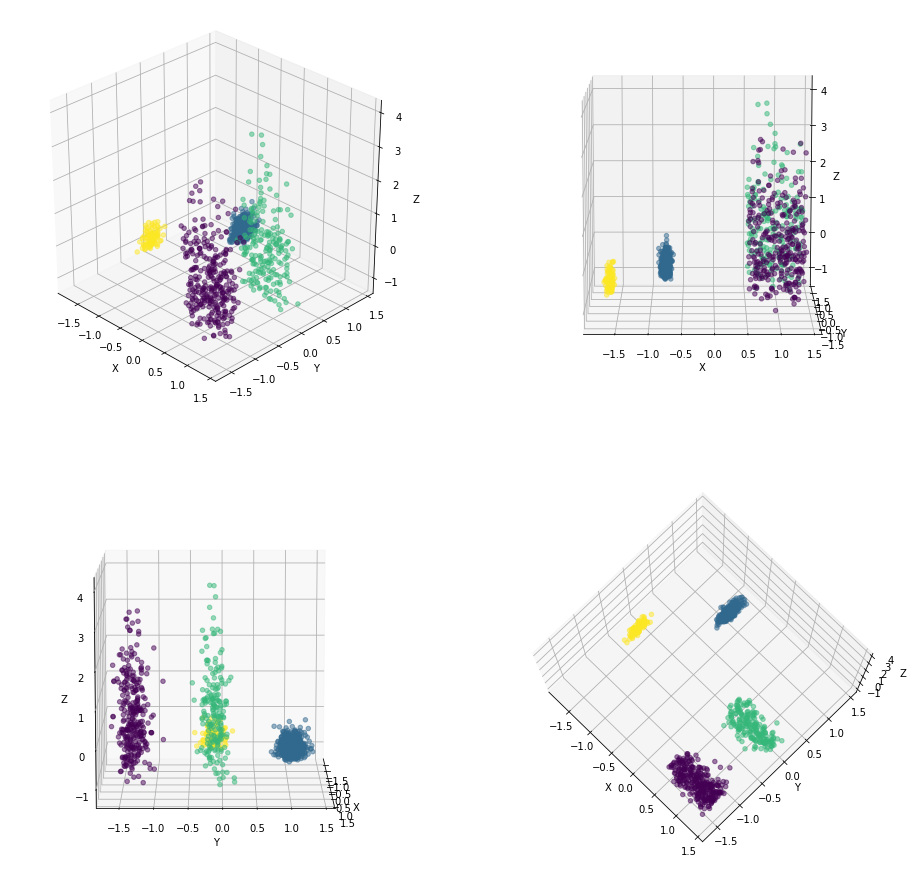

In [882]:
perspectives_plot(scaled_data, prediction)

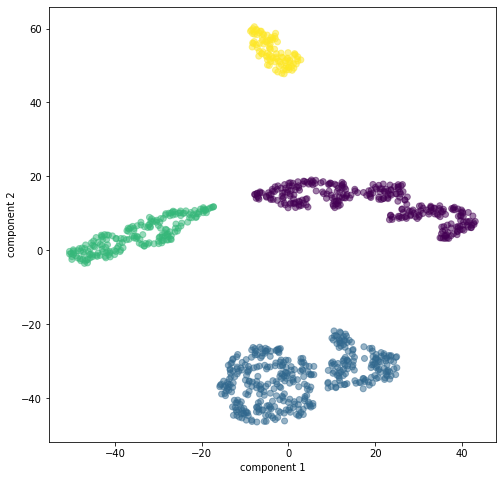

In [883]:
tsne_plot(scaled_data, prediction)

In [884]:
scores

{'silhouette_score': 0.6643641692874769,
 'calinski_harabasz_score': 3269.0231326701196,
 'davies_bouldin_score': 0.607814385262746}

In [885]:
result = pd.Series({'model': 'AC(ward)', 'scaling': 'MinMaxScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### StandardScaler

In [886]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
prediction, scores = predict_and_score(scaled_data_2, model)

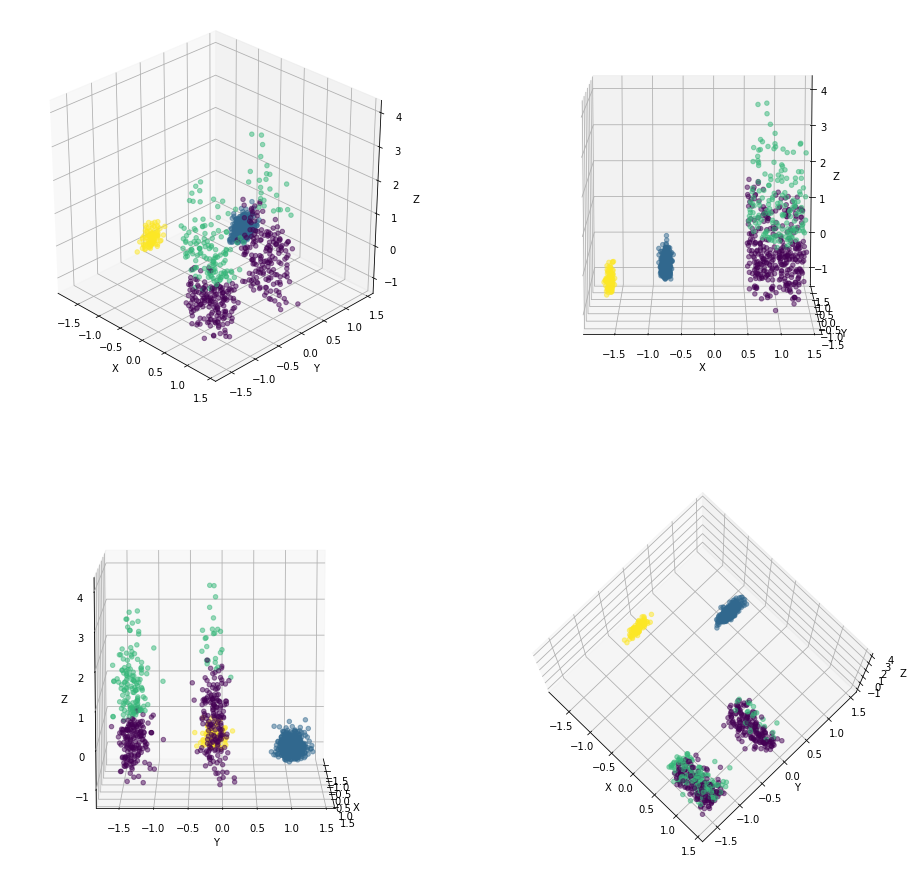

In [887]:
perspectives_plot(scaled_data, prediction)

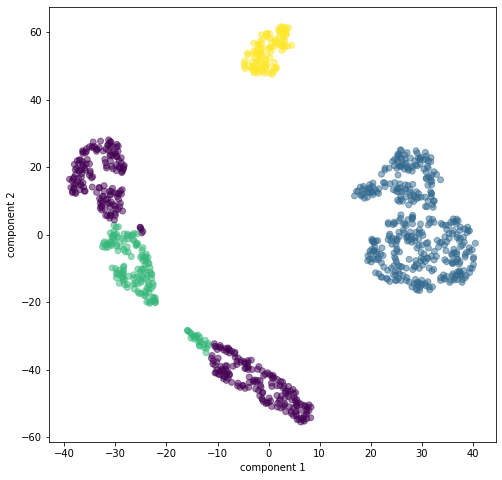

In [888]:
tsne_plot(scaled_data, prediction)

In [889]:
scores

{'silhouette_score': 0.5693632184875614,
 'calinski_harabasz_score': 1902.0065018082703,
 'davies_bouldin_score': 0.7508775413493225}

In [890]:
result = pd.Series({'model': 'AC(ward)', 'scaling': 'StandardScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

#### RobustScaler

In [891]:
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
prediction, scores = predict_and_score(scaled_data_3, model)

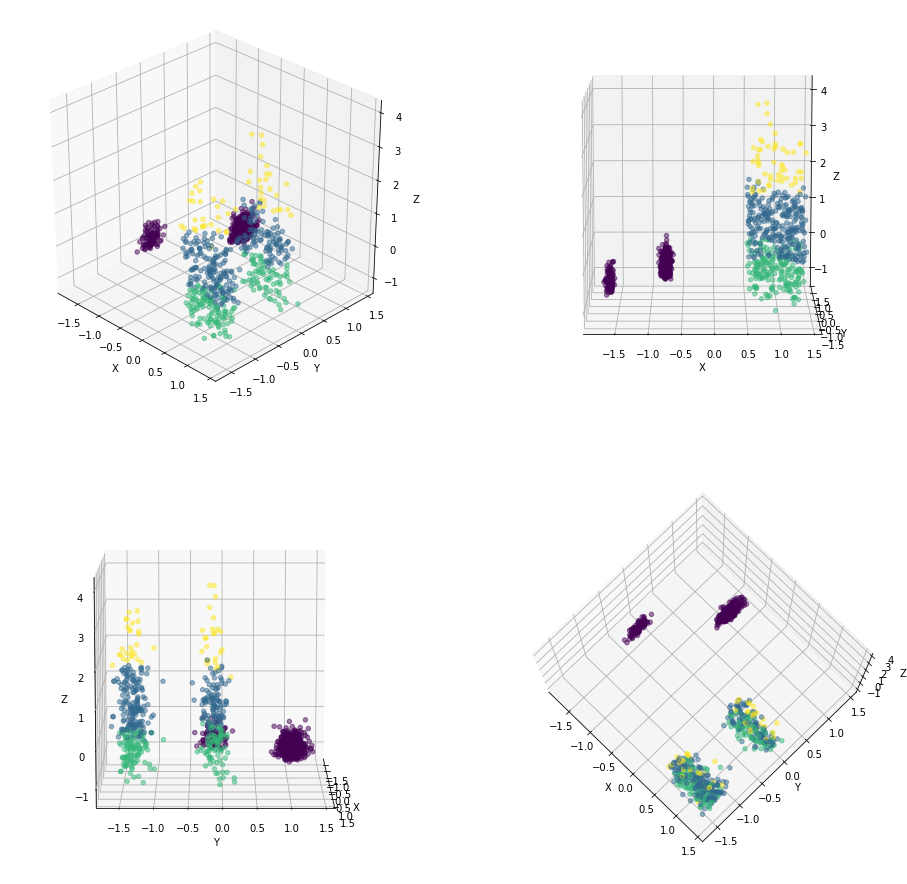

In [892]:
perspectives_plot(scaled_data, prediction)

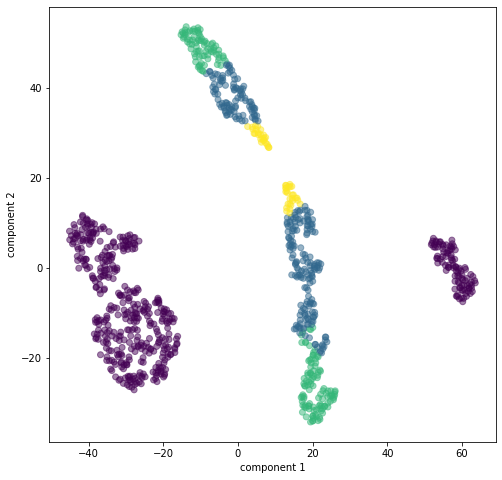

In [893]:
tsne_plot(scaled_data, prediction)

In [894]:
scores

{'silhouette_score': 0.5476379379603836,
 'calinski_harabasz_score': 1988.2153165749928,
 'davies_bouldin_score': 0.7735751100773471}

In [895]:
result = pd.Series({'model': 'AC(ward)', 'scaling': 'RobustScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

### AffinityPropagation - single

#### Brak skalowania

In [896]:
model = AgglomerativeClustering(n_clusters=4, linkage='single')
prediction, scores = predict_and_score(data, model)

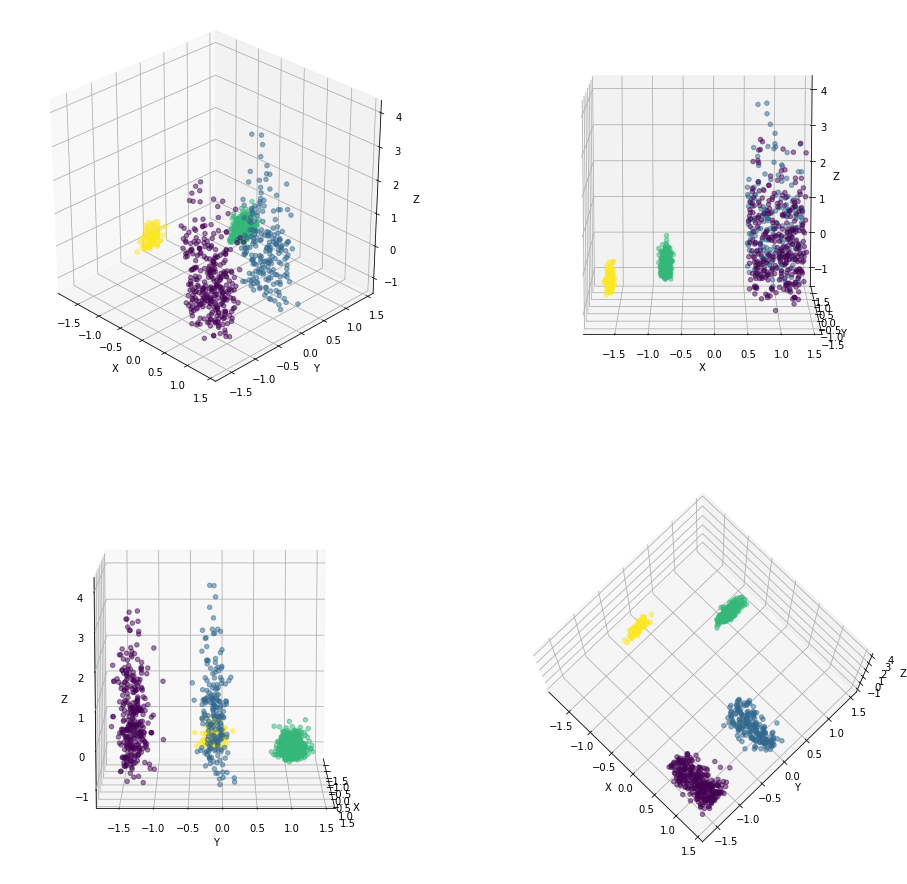

In [897]:
perspectives_plot(scaled_data, prediction)

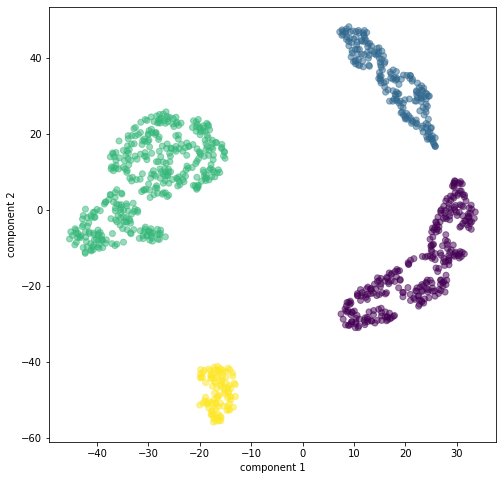

In [898]:
tsne_plot(scaled_data, prediction)

In [899]:
scores

{'silhouette_score': 0.6837538942794454,
 'calinski_harabasz_score': 10517.009359038915,
 'davies_bouldin_score': 0.5919841841278377}

In [900]:
result = pd.Series({'model': 'AC(single)', 'scaling': 'none',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### MinMaxScaler

In [901]:
model = AgglomerativeClustering(n_clusters=4, linkage='single')
prediction, scores = predict_and_score(scaled_data_1, model)

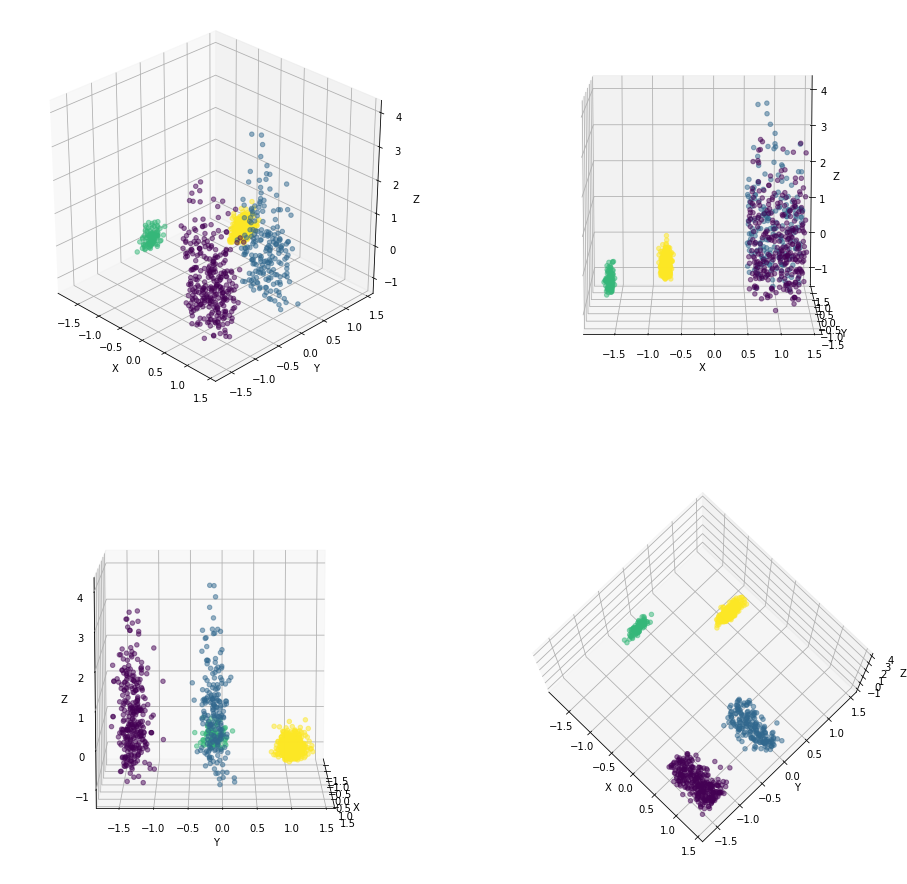

In [902]:
perspectives_plot(scaled_data, prediction)

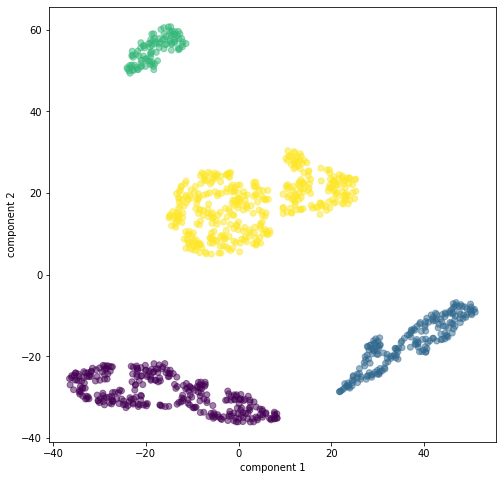

In [903]:
tsne_plot(scaled_data, prediction)

In [904]:
scores

{'silhouette_score': 0.6643641692874769,
 'calinski_harabasz_score': 3269.0231326701205,
 'davies_bouldin_score': 0.607814385262746}

In [905]:
result = pd.Series({'model': 'AC(single)', 'scaling': 'MinMaxScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### StandardScaler

In [906]:
model = AgglomerativeClustering(n_clusters=4, linkage='single')
prediction, scores = predict_and_score(scaled_data_2, model)

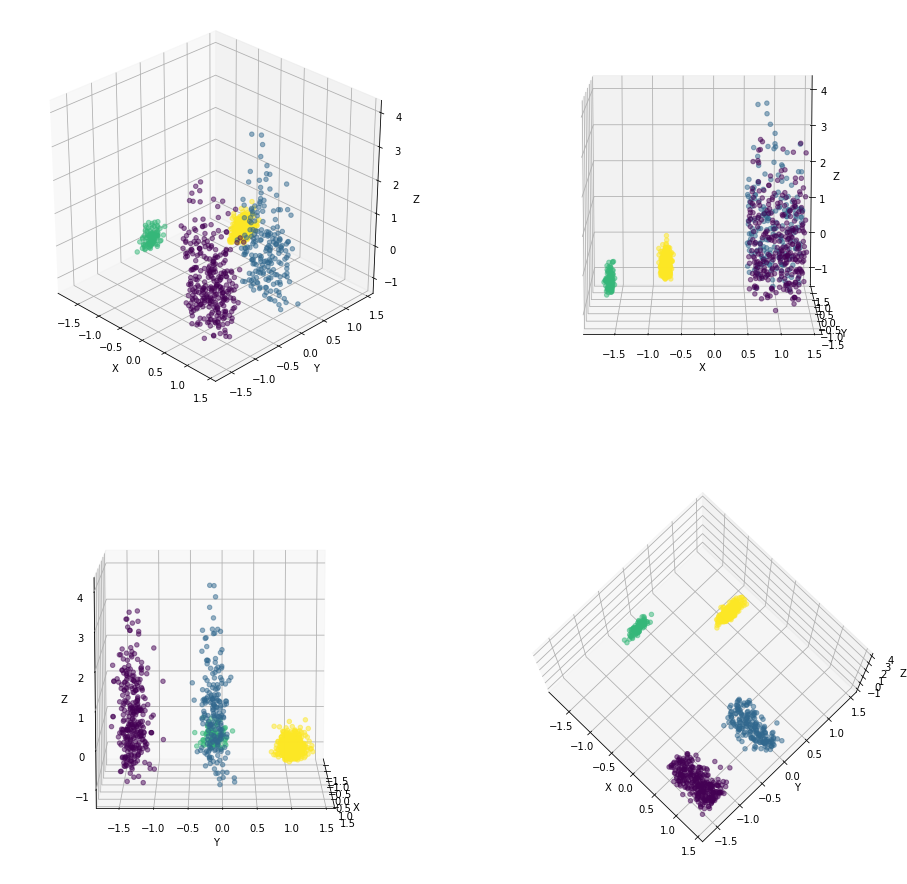

In [907]:
perspectives_plot(scaled_data, prediction)

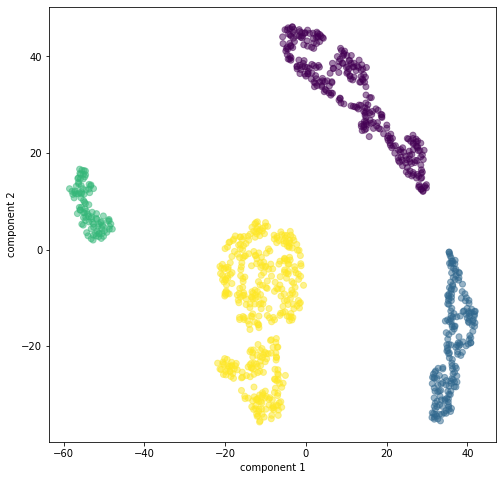

In [908]:
tsne_plot(scaled_data, prediction)

In [909]:
scores

{'silhouette_score': 0.5700917037724569,
 'calinski_harabasz_score': 1574.6009796328246,
 'davies_bouldin_score': 0.8977028253801611}

In [910]:
result = pd.Series({'model': 'AC(single)', 'scaling': 'StandardScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### RobustScaler

In [911]:
model = AgglomerativeClustering(n_clusters=4, linkage='single')
prediction, scores = predict_and_score(scaled_data_3, model)

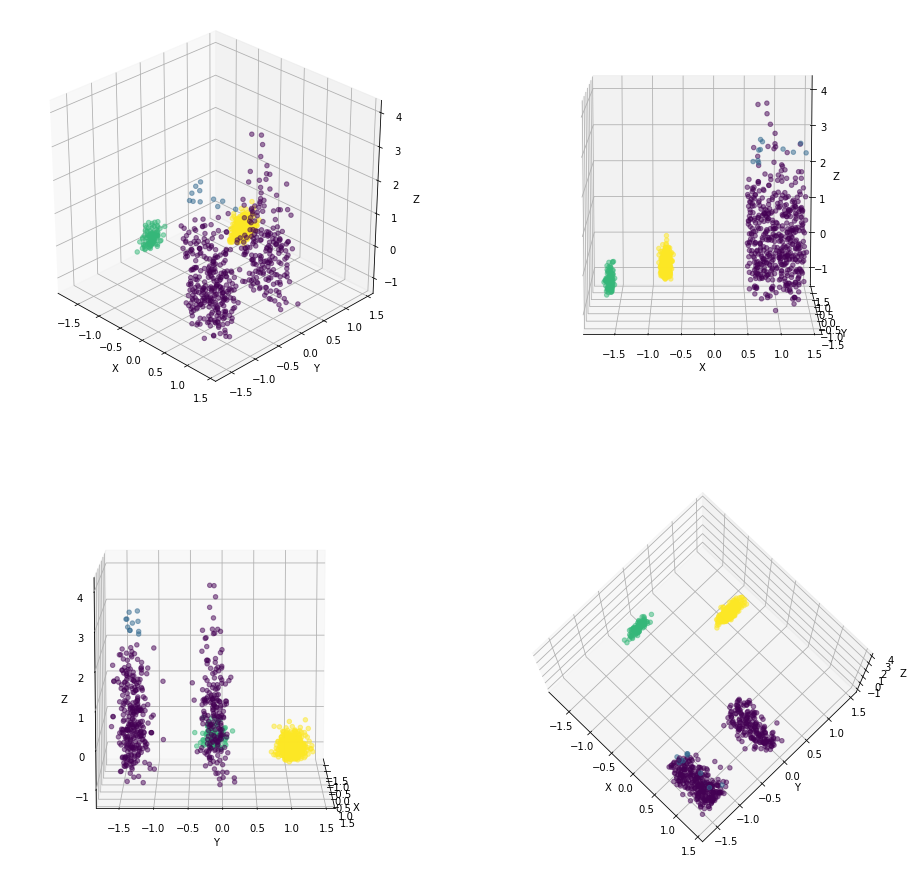

In [912]:
perspectives_plot(scaled_data, prediction)

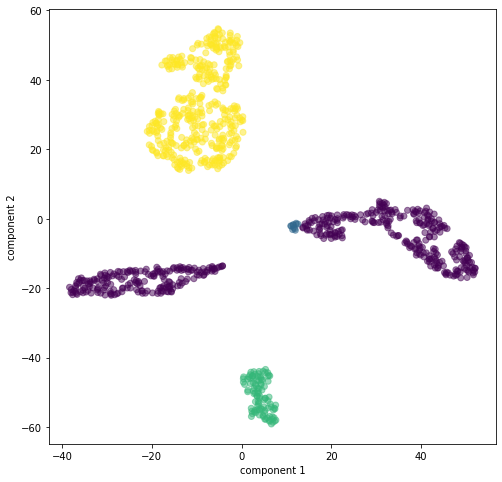

In [913]:
tsne_plot(scaled_data, prediction)

In [914]:
scores

{'silhouette_score': 0.5317708507335426,
 'calinski_harabasz_score': 963.8465297067444,
 'davies_bouldin_score': 0.4686232445020888}

In [915]:
result = pd.Series({'model': 'AC(single)', 'scaling': 'RobustScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

### MeanShift

#### Brak skalowania

In [916]:
bandwidth = estimate_bandwidth(data)
model = MeanShift(bandwidth=bandwidth)
prediction, scores = predict_and_score(data, model)

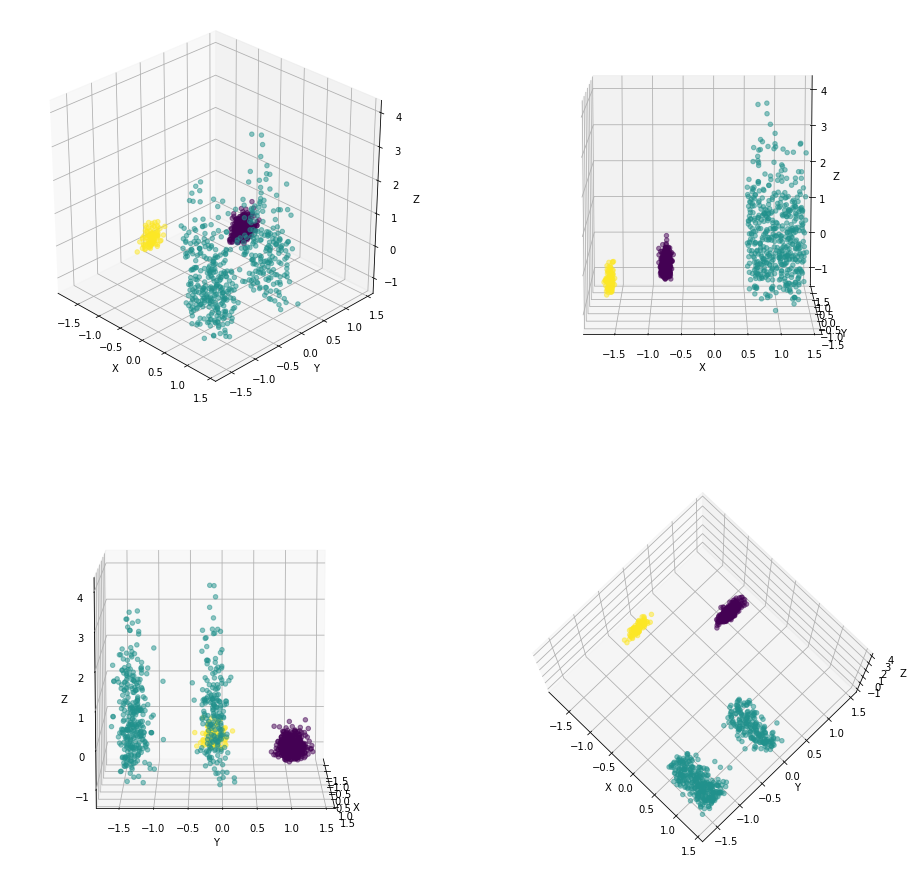

In [917]:
perspectives_plot(scaled_data, prediction)

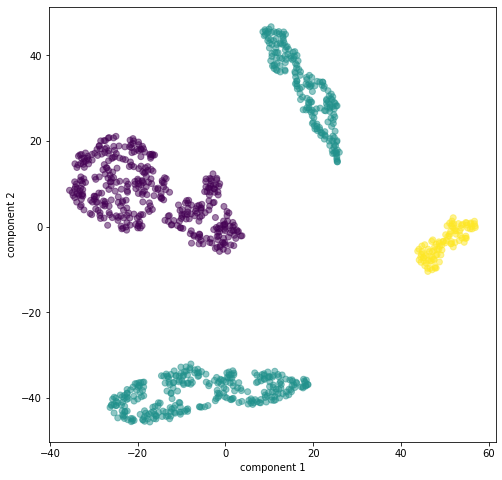

In [918]:
tsne_plot(scaled_data, prediction)

In [919]:
scores

{'silhouette_score': 0.8462944352356326,
 'calinski_harabasz_score': 9342.15724417534,
 'davies_bouldin_score': 0.18034069384321594}

In [920]:
result = pd.Series({'model': 'MeanShift', 'scaling': 'none',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

#### MinMaxScaler

In [921]:
bandwidth = estimate_bandwidth(scaled_data_1)
model = MeanShift(bandwidth=bandwidth)
prediction, scores = predict_and_score(scaled_data_1, model)

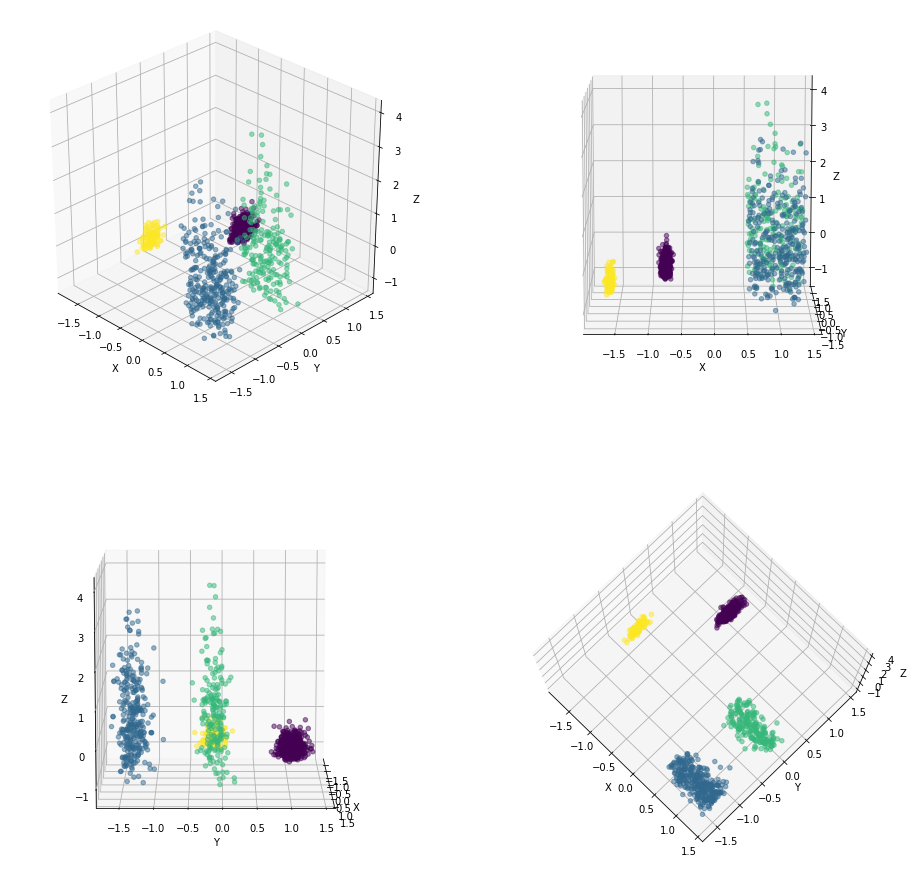

In [922]:
perspectives_plot(scaled_data, prediction)

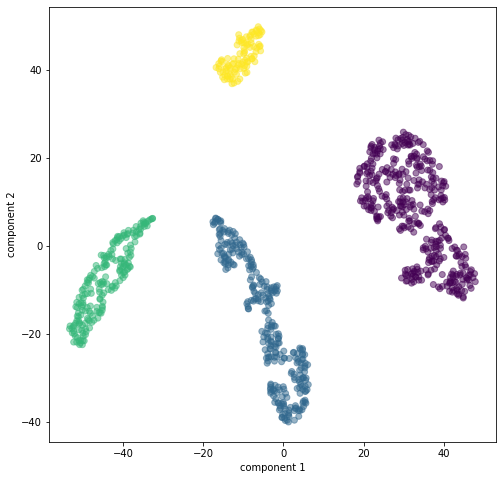

In [923]:
tsne_plot(scaled_data, prediction)

In [924]:
scores

{'silhouette_score': 0.6643641692874769,
 'calinski_harabasz_score': 3269.0231326701196,
 'davies_bouldin_score': 0.607814385262746}

In [925]:
result = pd.Series({'model': 'MeanShift', 'scaling': 'MinMaxScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 1})
results = results.append(result, ignore_index=True)

#### StandardScaler

In [926]:
bandwidth = estimate_bandwidth(scaled_data_2)
model = MeanShift(bandwidth=bandwidth)
prediction, scores = predict_and_score(scaled_data_2, model)

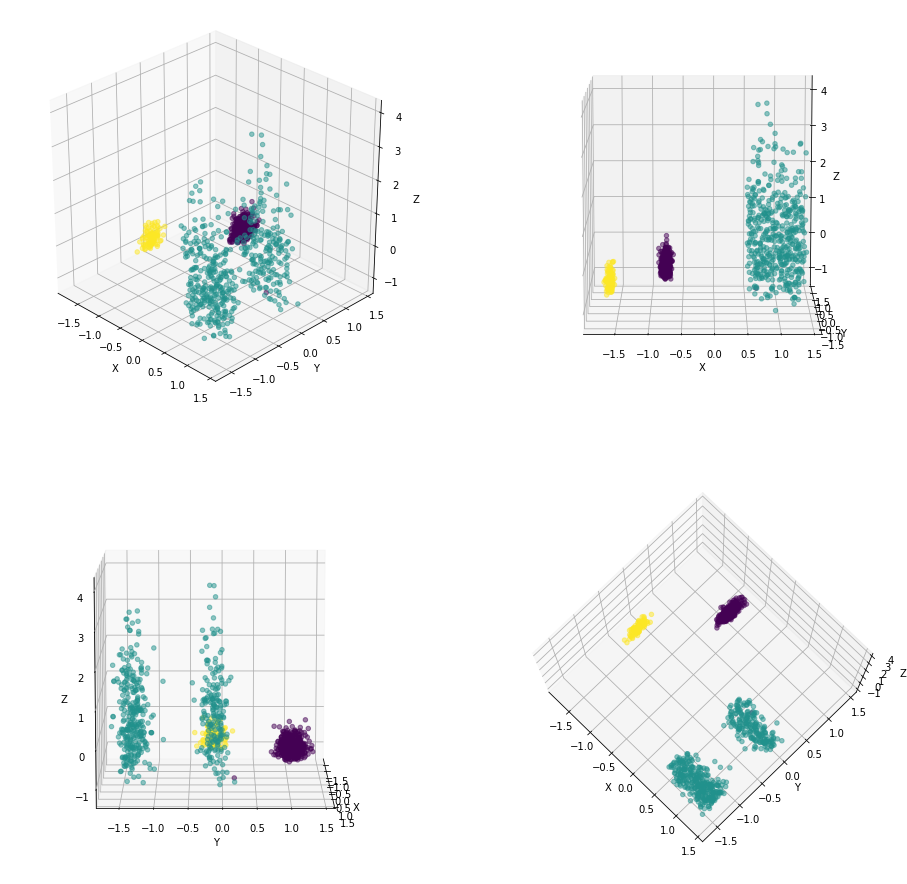

In [927]:
perspectives_plot(scaled_data, prediction)

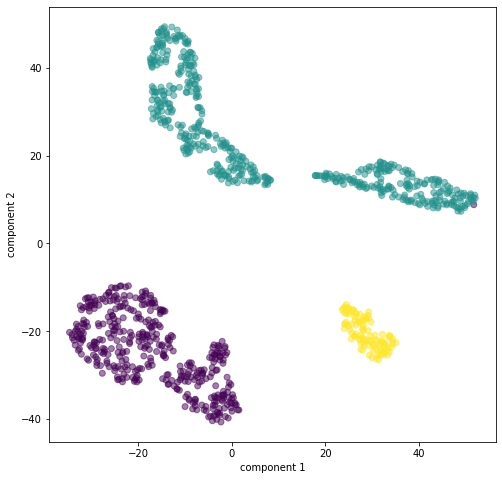

In [928]:
tsne_plot(scaled_data, prediction)

In [929]:
scores

{'silhouette_score': 0.65674316920675,
 'calinski_harabasz_score': 1658.3688961033306,
 'davies_bouldin_score': 0.4243199349719157}

In [930]:
result = pd.Series({'model': 'MeanShift', 'scaling': 'StandardScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

#### RobustScaler

In [931]:
bandwidth = estimate_bandwidth(scaled_data_3)
model = MeanShift(bandwidth=bandwidth)
prediction, scores = predict_and_score(scaled_data_3, model)

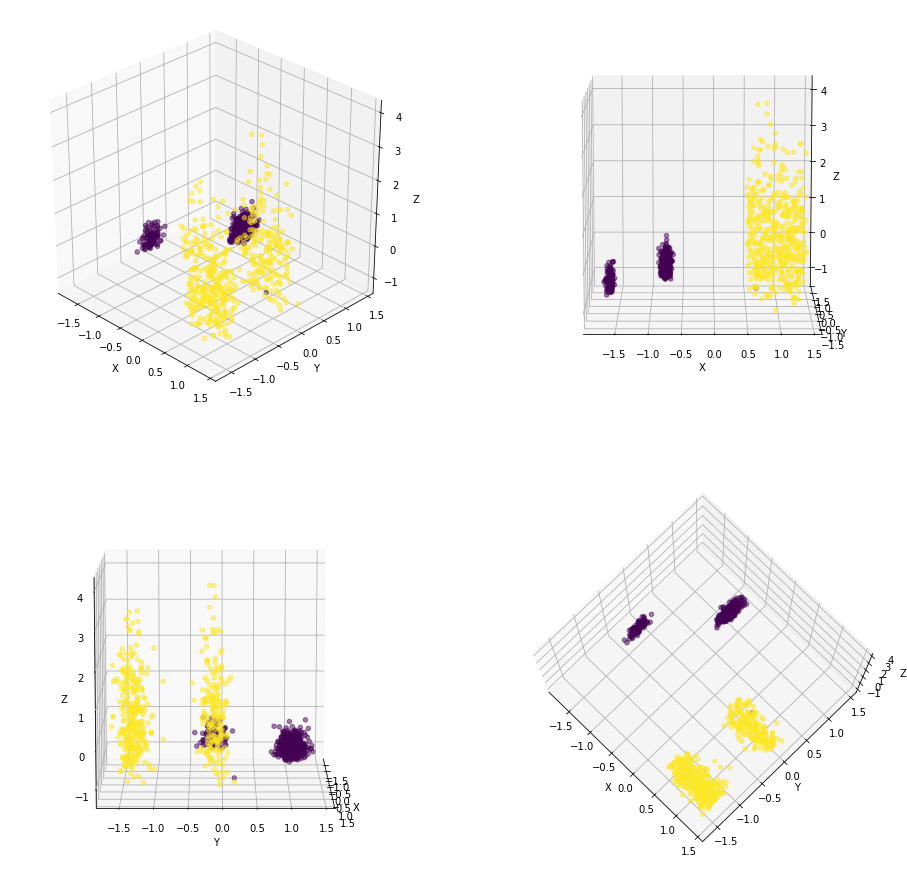

In [932]:
perspectives_plot(scaled_data, prediction)

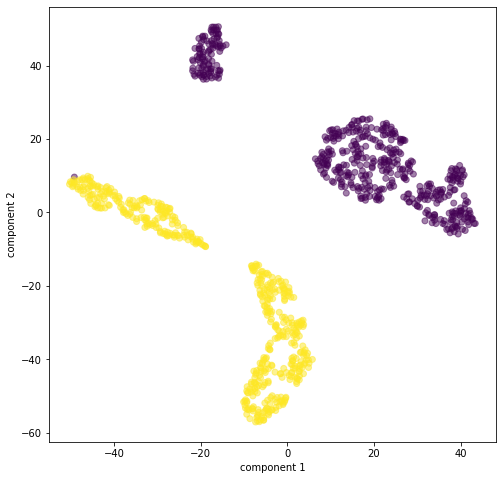

In [933]:
tsne_plot(scaled_data, prediction)

In [934]:
scores

{'silhouette_score': 0.6338513531429312,
 'calinski_harabasz_score': 2061.990274434879,
 'davies_bouldin_score': 0.5655281149859133}

In [935]:
result = pd.Series({'model': 'MeanShift', 'scaling': 'RobustScaler',
                    'silhouette_score': scores['silhouette_score'],
                    'calinski_harabasz_score': scores['calinski_harabasz_score'],
                    'davies_bouldin_score': scores['davies_bouldin_score'],
                    'visually_correct': 0})
results = results.append(result, ignore_index=True)

## Wyniki

Wyniki prezentują się w następujący sposób.

In [936]:
results

model         scaling  silhouette_score  calinski_harabasz_score  \
0       KMeans            none          0.661475             11023.108697   
1       KMeans    MinMaxScaler          0.664364              3269.023133   
2       KMeans  StandardScaler          0.591255              2205.005027   
3       KMeans    RobustScaler          0.589196              2148.063905   
4     AC(ward)            none          0.683754             10517.009359   
5     AC(ward)    MinMaxScaler          0.664364              3269.023133   
6     AC(ward)  StandardScaler          0.569363              1902.006502   
7     AC(ward)    RobustScaler          0.547638              1988.215317   
8   AC(single)            none          0.683754             10517.009359   
9   AC(single)    MinMaxScaler          0.664364              3269.023133   
10  AC(single)  StandardScaler          0.570092              1574.600980   
11  AC(single)    RobustScaler          0.531771               963.846530   
12   MeanShift            none          0.846294              9342.157244   
13   MeanShift    MinMaxScaler          0.664364              3269.023133   
14   MeanShift  StandardScaler          0.656743              1658.368896   
15   MeanShift    RobustScaler          0.633851              2061.990274   

    davies_bouldin_score visually_correct  
0               0.627937                0  
1               0.607814                1  
2               0.693110                0  
3               0.603442                0  
4               0.591984                1  
5               0.607814                1  
6               0.750878                0  
7               0.773575                0  
8               0.591984                1  
9               0.607814                1  
10              0.897703                1  
11              0.468623                0  
12              0.180341                0  
13              0.607814                1  
14              0.424320                0  
15              0.565528                0

Postać tabeli znacznie utrudnia wyciąganie wniosków. Z tego powodu, wyniki przedstawimy na 3 heatmapach, po jednej na każdą z metryk. Oprócz tego, zaznaczymy na nich wyniki dotyczące podziałów, które uznaliśmy za wizualnie poprawne (za pomocą koloru czerwonego).

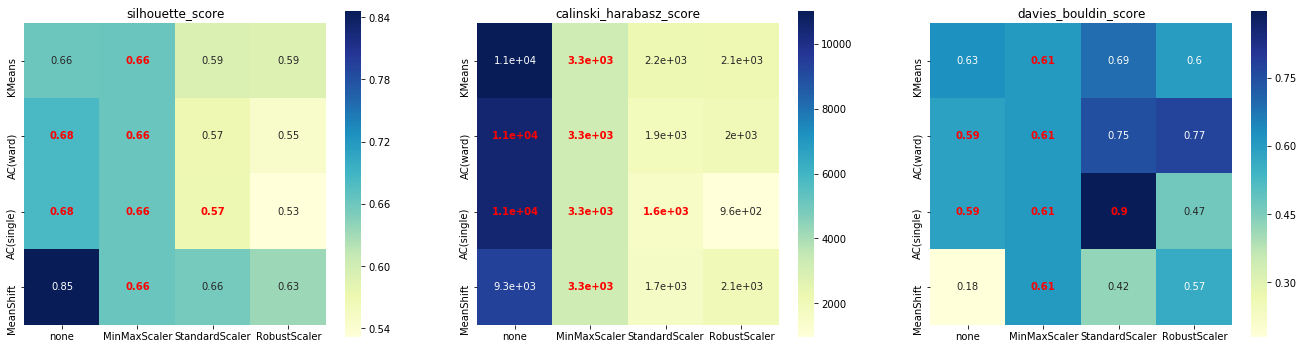

In [937]:
measures = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score']

fig, axes = plt.subplots(1, 3, figsize=(23, 6))

for i in range(3):
    plot_data = results.pivot('model', 'scaling', measures[i])
    row_order=['KMeans', 'AC(ward)', 'AC(single)', 'MeanShift']
    column_order = ['none', 'MinMaxScaler', 'StandardScaler', 'RobustScaler']
    plot_data = plot_data.reindex(row_order, axis=0)
    plot_data = plot_data.reindex(column_order, axis=1)
    mask = results.visually_correct.values

    sns.heatmap(data=plot_data, cmap="YlGnBu", annot=True, square=True, ax=axes[i])

    for j in range(len(axes[i].texts)):
        if mask[j]==1:
            axes[i].texts[j].set_weight('bold')
            axes[i].texts[j].set_color('red')
    
    axes[i].set_title(measures[i])

for ax in fig.axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

Obliczymy jeszcze współczynnik zmienności miary pośród poprawnych podziałów dla każdej z miar.

In [938]:
for measure in measures:
    print('Współczynnik zmienności miary %s pośród poprawnych podziałów wynosi: %.2f' % (measure, variation(results.loc[results['visually_correct']==1, measure])))

Współczynnik zmienności miary silhouette_score pośród poprawnych podziałów wynosi: 0.06
Współczynnik zmienności miary calinski_harabasz_score pośród poprawnych podziałów wynosi: 0.68
Współczynnik zmienności miary davies_bouldin_score pośród poprawnych podziałów wynosi: 0.16


## Wnioski

Analiza powyższych wykresów i obliczeń pozwala dojść do poniższych wniosków.

* Wyższy Silhouette Score jest uznawany za lepszy, jednak w naszym przypadku najwyższa jego wartość nie jest związana z poprawnym podziałem. Co więcej, wśród kilku podziałów o bardzo zbliżonym Silhouette Score kilka z nich jest poprawnych, a kilka nie.

* Wyższy Calinski Harabasz Score jest uznawany za lepszy, jednak w naszym przypadku najwyższa jego wartość nie jest związana z poprawnym podziałem. Co więcej, wśród kilku podziałów o bardzo zbliżonym Calinski Harabasz Score kilka z nich jest poprawnych, a kilka nie. Ponadto, sama wartość Calinski Harabasz Score zdaje się w tym przypadku bardziej zależeć od metody skalowania, niż zastosowanego algorytmu klasteryzacji.

* Niższy Davies Bouldin Score jest uznawany za lepszy, jednak w naszym przypadku najniższa jego wartość nie jest związana z poprawnym podziałem. Co więcej, wśród kilku podziałów o bardzo zbliżonym Davies Bouldin Score kilka z nich jest poprawnych, a kilka nie.

* Modelem, dla którego osiągnięto największą liczbę poprawnych podziałów (dla 3 metod skalowania) jest AgglomerativeClustering z paramatrem linkage='single'.

* Metodą skalowania, dla której osiągnięto największą liczbę poprawnych podziałów (dla wszystkich modeli) jest MinMaxScaler.

* Najmniejszy współczynnik zmienności pośród poprawnych podziałów wykazuje Silhouette Score (0.06), nieco większy Calinski Harabasz Score (0.16), a największy Davies Bouldin Score (0.68).

Co ciekawe, nawet proste spojrzenie na wszystkie metryki jednocześnie pozwala na wytypowanie poprawnych podziałów dokładniej, niż w przypadku użycia tylko jednej z nich. Dla każdej metryki możemy wyznaczyć najmniejszy przedział, w którym mieszczą się wyniki wszystkich poprawnych podziałów. Następnie, możemy przefiltrować uzyskane wyniki za pomocą takiego przedziału i wytypować poprawne podziały. Użycie wszystkich dostępnych metryk w tym procesie (a zatem stworzenie pewnego obszaru w przestrzeni wszystkich metryk) poprawia nasze typowanie:

In [939]:
filter_1 = (results.silhouette_score>=min(results.loc[results.visually_correct==1, 'silhouette_score'])) & (result.silhouette_score<=max(results.loc[results.visually_correct==1, 'silhouette_score']))
filter_2 = (results.calinski_harabasz_score>=min(results.loc[results.visually_correct==1, 'calinski_harabasz_score'])) & (result.calinski_harabasz_score<=max(results.loc[results.visually_correct==1, 'calinski_harabasz_score']))
filter_3 = (results.davies_bouldin_score>=min(results.loc[results.visually_correct==1, 'davies_bouldin_score'])) & (result.davies_bouldin_score<=max(results.loc[results.visually_correct==1, 'davies_bouldin_score']))

In [940]:
print('Przedział dla metryki Silhouette Score typuje %d podziałów.'%(sum(filter_1)))

Przedział dla metryki Silhouette Score typuje 13 podziałów.


In [941]:
print('Przedział dla metryki Calinski Harabasz Score typuje %d podziałów.'%(sum(filter_2)))

Przedział dla metryki Calinski Harabasz Score typuje 15 podziałów.


In [942]:
print('Przedział dla metryki Davies Bouldin Score typuje %d podziałów.'%(sum(filter_3)))

Przedział dla metryki Davies Bouldin Score typuje 12 podziałów.


In [943]:
print('Obszar dla wszystkich metryk typuje %d podziałów.'%(sum(filter_1 & filter_2 & filter_3)))

Obszar dla wszystkich metryk typuje 10 podziałów.


In [944]:
print('W rzeczywistości jest %d poprawnych podziałów.'%(sum(results.visually_correct)))

W rzeczywistości jest 7 poprawnych podziałów.


Podejście to, choć działa, jest bardzo proste, a co za tym idzie, nie daje idealnych wyników. Być może użycie większej ilości metryk w połączeniu z algorytmem uczenia maszynowego pozwoliłoby na dokładniejsze typowanie poprawnych podziałów? Oczywiście etykietowanie zbioru treningowego musiałoby odbyć się ręcznie, co zapewne okazałoby się bardzo czasochłonne.